In [8]:
from transformers import VideoMAEConfig, VideoMAEForPreTraining , ViTMAEConfig , ViTMAEForPreTraining
import torch
from torch import nn

In [ ]:
vit_config = ViTMAEConfig(image_size=image_size, tubelet_size=tubelet_size, num_channels=num_channels, num_frames=num_frames, patch_size= patch_size)




In [14]:
from transformers import AutoImageProcessor, ViTMAEForPreTraining
from PIL import Image
import requests

url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
image = Image.open(requests.get(url, stream=True).raw)

processor = AutoImageProcessor.from_pretrained('facebook/vit-mae-base')
model = ViTMAEForPreTraining.from_pretrained('facebook/vit-mae-base')

inputs = processor(images=image, return_tensors="pt")
outputs = model(**inputs)
loss = outputs.loss
mask = outputs.mask
ids_restore = outputs.ids_restore


loading configuration file preprocessor_config.json from cache at /home/users/shubham.kumar/.cache/huggingface/hub/models--facebook--vit-mae-base/snapshots/f4bf8a536816f4f7d5c8b7fbd4621396c195001f/preprocessor_config.json
loading configuration file config.json from cache at /home/users/shubham.kumar/.cache/huggingface/hub/models--facebook--vit-mae-base/snapshots/f4bf8a536816f4f7d5c8b7fbd4621396c195001f/config.json
Model config ViTMAEConfig {
  "_name_or_path": "facebook/vit-mae-base",
  "architectures": [
    "ViTMAEForPreTraining"
  ],
  "attention_probs_dropout_prob": 0.0,
  "decoder_hidden_size": 512,
  "decoder_intermediate_size": 2048,
  "decoder_num_attention_heads": 16,
  "decoder_num_hidden_layers": 8,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "mask_ratio": 0.75,
  "model_type": "vit_mae",
  "norm_pix_loss": false,
  "num_attention_heads"

In [36]:
model.config

ViTMAEConfig {
  "_name_or_path": "facebook/vit-mae-base",
  "architectures": [
    "ViTMAEForPreTraining"
  ],
  "attention_probs_dropout_prob": 0.0,
  "decoder_hidden_size": 512,
  "decoder_intermediate_size": 2048,
  "decoder_num_attention_heads": 16,
  "decoder_num_hidden_layers": 8,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "mask_ratio": 0.75,
  "model_type": "vit_mae",
  "norm_pix_loss": false,
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": true,
  "torch_dtype": "float32",
  "transformers_version": "4.34.0"
}

In [25]:
from transformers.models.vit_mae.modeling_vit_mae import ViTMAEPatchEmbeddings, get_2d_sincos_pos_embed ,ViTMAEEmbeddings

In [19]:
emb = ViTMAEEmbeddings(model.config)

In [38]:
emb.position_embeddings.shape

torch.Size([1, 197, 768])

In [37]:
import matplotlib.pyplot as plt

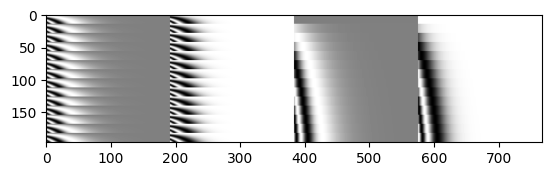

In [41]:
plt.imshow(emb.position_embeddings[0],cmap ="gray")
plt.show()

In [24]:
emb.patch_embeddings

ViTMAEPatchEmbeddings(
  (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
)

In [46]:
(32//2)*(32//2)

256

In [48]:
position_embeddings = nn.Parameter(
            torch.zeros(1, 256 + 1, 768), requires_grad=False
        )

In [50]:
position_embeddings.shape

torch.Size([1, 257, 768])

In [51]:
pos_embed = get_2d_sincos_pos_embed(
            position_embeddings.shape[-1], int(256**0.5), add_cls_token=True
        )

In [53]:
pos_embed.shape

(257, 768)

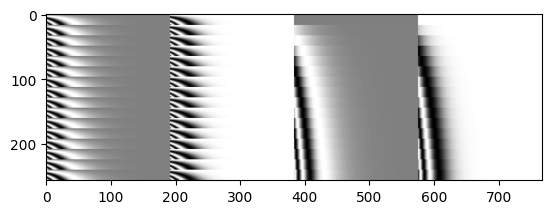

In [54]:
plt.imshow(pos_embed,cmap="gray")
plt.show()

In [55]:
def get_2d_sincos_pos_embed(embed_dim, grid_size, add_cls_token=False):
    """
    Create 2D sin/cos positional embeddings.

    Args:
        embed_dim (`int`):
            Embedding dimension.
        grid_size (`int`):
            The grid height and width.
        add_cls_token (`bool`, *optional*, defaults to `False`):
            Whether or not to add a classification (CLS) token.

    Returns:
        (`torch.FloatTensor` of shape (grid_size*grid_size, embed_dim) or (1+grid_size*grid_size, embed_dim): the
        position embeddings (with or without classification token)
    """
    grid_h = np.arange(grid_size, dtype=np.float32)
    grid_w = np.arange(grid_size, dtype=np.float32)
    grid = np.meshgrid(grid_w, grid_h)  # here w goes first
    grid = np.stack(grid, axis=0)

    grid = grid.reshape([2, 1, grid_size, grid_size])
    pos_embed = get_2d_sincos_pos_embed_from_grid(embed_dim, grid)
    if add_cls_token:
        pos_embed = np.concatenate([np.zeros([1, embed_dim]), pos_embed], axis=0)
    return pos_embed


def get_2d_sincos_pos_embed_from_grid(embed_dim, grid):
    if embed_dim % 2 != 0:
        raise ValueError("embed_dim must be even")

    # use half of dimensions to encode grid_h
    emb_h = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[0])  # (H*W, D/2)
    emb_w = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[1])  # (H*W, D/2)

    emb = np.concatenate([emb_h, emb_w], axis=1)  # (H*W, D)
    return emb


def get_1d_sincos_pos_embed_from_grid(embed_dim, pos):
    """
    embed_dim: output dimension for each position pos: a list of positions to be encoded: size (M,) out: (M, D)
    """
    if embed_dim % 2 != 0:
        raise ValueError("embed_dim must be even")

    omega = np.arange(embed_dim // 2, dtype=float)
    omega /= embed_dim / 2.0
    omega = 1.0 / 10000**omega  # (D/2,)

    pos = pos.reshape(-1)  # (M,)
    out = np.einsum("m,d->md", pos, omega)  # (M, D/2), outer product

    emb_sin = np.sin(out)  # (M, D/2)
    emb_cos = np.cos(out)  # (M, D/2)

    emb = np.concatenate([emb_sin, emb_cos], axis=1)  # (M, D)
    return emb

In [27]:
from transformers import AutoImageProcessor, VideoMAEForPreTraining
import numpy as np
import torch

num_frames = 16
video = list(np.random.randint(0, 256, (num_frames, 3, 224, 224)))

image_processor = AutoImageProcessor.from_pretrained("MCG-NJU/videomae-base")
video_model = VideoMAEForPreTraining.from_pretrained("MCG-NJU/videomae-base")

pixel_values = image_processor(video, return_tensors="pt").pixel_values

num_patches_per_frame = (video_model.config.image_size // video_model.config.patch_size) ** 2
seq_length = (num_frames // video_model.config.tubelet_size) * num_patches_per_frame
bool_masked_pos = torch.randint(0, 2, (1, seq_length)).bool()

outputs = video_model(pixel_values, bool_masked_pos=bool_masked_pos)
loss = outputs.loss

loading configuration file preprocessor_config.json from cache at /home/users/shubham.kumar/.cache/huggingface/hub/models--MCG-NJU--videomae-base/snapshots/ef591f7f4f124a942b24089abfa75f6a12c23593/preprocessor_config.json
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
size should be a dictionary on of the following set of keys: ({'height', 'width'}, {'shortest_edge'}, {'longest_edge', 'shortest_edge'}, {'longest_edge'}), got 224. Converted to {'shortest_edge': 224}.
Image processor VideoMAEImageProcessor {
  "crop_size": {
    "height": 224,
    "width": 224
  },
  "do_center_crop": true,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "VideoMAEImageProcessor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 2,
  "rescale_factor": 0.003921568627

In [44]:
seq_length

1568

In [28]:
from transformers.models.videomae.modeling_videomae import VideoMAEEmbeddings

In [29]:
vide_emb = VideoMAEForPreTraining(video_model.config)

In [42]:
vide_emb.position_embeddings.shape

torch.Size([1, 1568, 384])

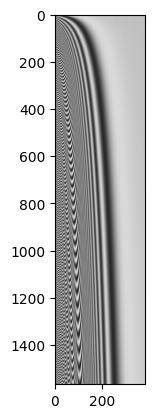

In [43]:
plt.imshow(vide_emb.position_embeddings[0],cmap ="gray")
plt.show()

In [34]:
video_model.config

VideoMAEConfig {
  "_name_or_path": "MCG-NJU/videomae-base",
  "architectures": [
    "VideoMAEForPreTraining"
  ],
  "attention_probs_dropout_prob": 0.0,
  "decoder_hidden_size": 384,
  "decoder_intermediate_size": 1536,
  "decoder_num_attention_heads": 6,
  "decoder_num_hidden_layers": 4,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "videomae",
  "norm_pix_loss": true,
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_frames": 16,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": true,
  "torch_dtype": "float32",
  "transformers_version": "4.34.0",
  "tubelet_size": 2,
  "use_mean_pooling": false
}